In [1]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageFilter
from PIL import Image
import torchvision.transforms.functional as F
from torchvision.datasets import ImageFolder

### Initialize device

In [2]:
ngpu = 1
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

### Parameters for loading model, defining architecture, and forward propagation

In [30]:
# Path to the .pth file
model_dir = '../models/second_stage/ResNet_9/early_stop-264181/'
model_path = model_dir + 'netG.pth'

# Directory for edge images input
edges_dir = '../data/CelebA/edges_grayscale/large/edges/'
# edges_dir = '../data/baseline_samples/new/'

# Number of workers for dataloader
workers = 2

# Number of channels in the training images. 3 for color images and 1 for grayscale images.
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Images to display at once
batch = 64

# Number of samples to display
samples = batch

# Constant noise vector. This is fine since we only do one forward pass of the network in this notebook.
fixed_noise = torch.randn(samples, nz, 1, 1, device=device)

### Define model architecture

In [31]:
class ResnetBlock(nn.Module):

    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            nn.InstanceNorm2d(dim),
        ]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        # Skip connection
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(nc, ngf, kernel_size=7, padding=0, bias=True),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True),
        ]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [
                nn.Conv2d(
                    ngf * mult,
                    ngf * mult * 2,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    bias=True,
                ),
                nn.InstanceNorm2d(ngf * mult * 2),
                nn.ReLU(True),
            ]

        mult = 2 ** n_downsampling
        for i in range(9):  # ResNet-6 requires 6 blocks

            model += [
                ResnetBlock(ngf * mult)
            ]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [
                nn.ConvTranspose2d(
                    ngf * mult,
                    int(ngf * mult / 2),
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                    bias=True,
                ),
                nn.InstanceNorm2d(int(ngf * mult / 2)),
                nn.ReLU(True),
            ]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)

### Load conditional input

In [5]:
transform = transforms.Compose([    
                transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
trainset = ImageFolder(root=edges_dir, transform=transform)
dataloader = DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=workers)

### Load generator from trained 'model.pth'

In [32]:
model = Generator()
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

### Load in batch once

In [34]:
inputs = next(iter(dataloader))

### Visualize generated images

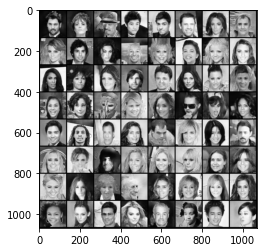

In [37]:
with torch.no_grad():
    x = inputs[0][:samples]
    # x = np.rot90(x,axes=(-2,-1))
    # tensor = torch.from_numpy(np.flip(x,axis=0).copy())
    tensor = x
    input_imgs = np.transpose(vutils.make_grid(tensor, padding = 5, normalize=True), (1, 2, 0))
    fake_image = model(tensor).to(device)
    output_imgs = np.transpose(vutils.make_grid(fake_image, padding = 5, normalize=True), (1, 2, 0))
    plt.imshow(output_imgs, cmap='gray')
    plt.imsave(model_dir + 'out.png', np.array(output_imgs), cmap='gray')
    plt.imsave(model_dir + 'in.png', np.array(input_imgs), cmap='gray')